In [2]:
import numpy as np
import h5py
import torch
import torchmetrics
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder 

from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, MSELoss, Softmax, CrossEntropyLoss
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch


In [3]:
path='../project_data/small_set_1_train_0_shuffled.h5'

In [4]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=16,scaling=None):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            self.length = len(f["y"]) // batch_size + 1
            self._max_index = len(f["y"])
            self.encoder=OneHotEncoder(sparse=False)
            self.encoder.fit(f["y"][:2000]['particle_type'].reshape(-1,1))
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.scaling=scaling
        self.batch_size = batch_size
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)


    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self, index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label 

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            index = slice(index * self.batch_size, min(self._max_index,(index + 1) * self.batch_size))
            
            x = f["x"][index]
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                  [
                      np.ones(length) * batch_idx
                      for batch_idx, length in enumerate(lengths)
                  ]
              )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            y = f["y"][index][self.y_feature].reshape(-1,1)
            if self.scaling == 'log':
                y = torch.log(torch.Tensor(y.copy()))
            else:
                y = torch.Tensor(y.copy())
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length

In [5]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        #self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 8, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)

        self.shortcut_1 = Sequential(Linear(8, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())


        self.lin_2 = Linear(128, 128)
        self.lin_3 = Linear(128, 1)

    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
      
        x = global_mean_pool(x, batch=batch_idx)
        # now apply

        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return F.relu(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss)
        #self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log("val_loss", loss)
        #self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        predictions_pred.append(y_hat)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        #self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_pred': y_hat}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [6]:
features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"]
train_data = HDF5Dataset(path,features=features, y_feature="energy",particle_type=None, batch_size=32,scaling='log')

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=features, y_feature="energy",particle_type=None, batch_size=32,scaling='log')

val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 

In [7]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_41/checkpoints/epoch=0-step=12842.ckpt')

In [8]:
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=10,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | edge_1     | DynamicEdgeConv | 9.8 K 
1 | edge_2     | DynamicEdgeConv | 50.3 K
2 | shortcut_1 | Sequential      | 704   
3 | shortcut_2 | Sequential      | 8.6 K 
4 | lin_2      | Linear          | 16.5 K
5 | lin_3      | Linear          | 129   
-----------------------------------------------
86.0 K    Trainable params
0         Non-trainable params
86.0 K    Total params
0.344     Total estimated model params size (MB)


Epoch 0:  84%|████████▍ | 12850/15336 [44:48<08:40,  4.78it/s, loss=1.71, v_num=42]
Validating: 0it [00:00, ?it/s]
Epoch 1:  84%|████████▍ | 12850/15336 [44:49<08:40,  4.78it/s, loss=1.65, v_num=42]
Validating: 0it [00:00, ?it/s]
Epoch 1:  92%|█████████▏| 14160/15336 [46:10<03:50,  5.11it/s, loss=1.65, v_num=42]

In [30]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

In [32]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_39/trained_model.ckpt')

In [45]:
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 2493/2493 [02:44<00:00, 15.17it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 1.742307424545288}
--------------------------------------------------------------------------------


[{'test_loss': 1.742307424545288}]

In [50]:
y_pred=np.empty(1)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    y_pred=np.vstack([y_pred,predictions_pred[i].cpu().numpy().reshape(-1,1)])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [68]:
np.exp(y_pred[1:])

79767

In [67]:
np.exp(y_actual[1:])

array([[4.52373062e+02],
       [7.34739053e+01],
       [2.27920985e+04],
       ...,
       [1.68460027e+02],
       [8.66190071e+02],
       [9.28040137e+00]])

In [58]:
import pandas as pd
path="../project_data/small_set_1_validate_0_shuffled.h5"
with h5py.File(path, "r") as f:
    df=pd.DataFrame(f['y'][:])

df.columns

Index(['event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x',
       'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x',
       'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2',
       'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y',
       'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x',
       'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length',
       'group_id'],
      dtype='object')

In [69]:
df['pred_energy']=np.exp(y_pred[1:])
df['relative_error_E']=np.abs(df.energy-df.pred_energy)/df.energy

In [77]:
df.relative_error_E.describe()

count    79767.000000
mean         1.071929
std          9.607987
min          0.000006
25%          0.317422
50%          0.618758
75%          0.924829
max       2457.571563
Name: relative_error_E, dtype: float64

In [81]:
particle_names={-13:'muon',14:'muon neutrino',-14:'muon neutrino',12:'electron neutrino',-12:'electron neutrino'}
df['particles']=df.particle_type.map(particle_names)

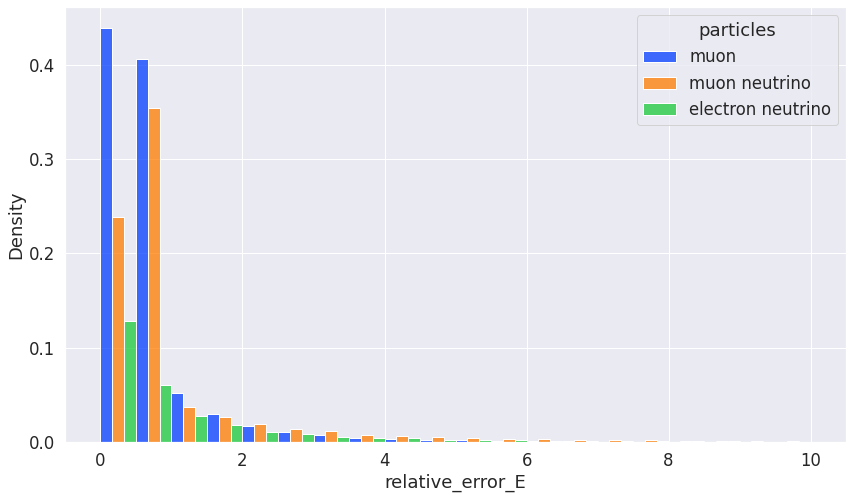

In [88]:
import seaborn as sns
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df, x='relative_error_E',hue='particles',multiple="dodge",stat='density', binwidth = 0.5,binrange=[0,10], palette="bright")
fig = sns_plot.get_figure()
fig.savefig("rel_error_energy.pdf")

In [1]:
df.relative_error_E

NameError: name 'df' is not defined